In [1]:
%cd ../..
# %pip install .
import time
from os import environ
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# point1 = OrientedPoint ahead of ego by Range(0, 40)
# Car at (point1 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection



/home/yongming/workspace/research/apperception_new_local/apperception


In [2]:
environ['AP_PORT'] = str(input('port')) # README command uses port=25432

port25432


In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
import random

experiment_data_dir =  "data/nuscenes/experiment_data"
# experiment_data_dir = '/work/apperception/data/nuScenes/full-dataset-v1.0/Trainval/experiment_data'
def show_images(images, sample=None):
    if sample is not None:
        images = [i for i in images]
        random.shuffle(images)
        images = images[:sample]
    
    plt.figure(figsize=(60,30))
    columns = 3

    for i, image in enumerate(images):
        print("image", image)
        img = mpimg.imread(os.path.join(experiment_data_dir, image))
        print("loaded")
        plt.subplot(len(images) // columns + 1, columns, i + 1)
        plt.imshow(img)

In [4]:
#### First part of the query ####
from apperception.world import empty_world
# directly ingest the mini dataset and boston roadnetwork if needed
# from apperception.database import database
# database.reset()
# from benchmarks.ingest_scenic_data import ingest_data
# ingest_data()


name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F
# world = world.predicate(lambda obj: obj.object_type == 'vehicle')
def pred(obj1, cam):
    return (
        F.like(obj1.object_type, 'vehicle%') and
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) > -15 and
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) < 15 and
        F.view_angle(obj1, cam.ego, cam.timestamp) < 67.5 and
        F.distance(cam.ego, obj1, cam.timestamp) < 40 and
        F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp) > -15 and 
        F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp) < 15 and
        F.ahead(obj1, cam.ego, cam.timestamp)
    )
world = world.filter("lambda obj1, cam: " +
        "F.like(obj1.object_type, 'vehicle%') and " +
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.view_angle(obj1, cam.ego, cam.timestamp) < 67.5 and " +
        "F.distance(cam.ego, obj1, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.ahead(obj1, cam.ego, cam.timestamp)")

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename_1 = world.get_id_time_camId_filename(num_joined_tables=1)

end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        
        JOIN Cameras USING (cameraId)
        WHERE ((table_0.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<67.5) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<40) AND angleBetween(facingRelative(table_0.itemHeadings, roadDirection(table_0.trajCentroids, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND ahead(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp))
        
done execute node
Result length: 39
5.89050555229187

In [ ]:
resultImages_1 = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename_1:
    itemId, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    resultImages_1[filename] = (itemId, timestamp, camId)

In [ ]:
show_images(list(resultImages_1.keys()))

In [ ]:
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# oppositeCar = Car offset by (Range(-10, -1), Range(0, 50)),
#     facing Range(140, 180) deg relative to ego.heading

# point2 = OrientedPoint ahead of oppositeCar by Range(0, 40)
# Car at (point2 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection

In [8]:
### Second part of the query ###
from apperception.world import empty_world

name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F

world = world.filter("lambda obj1, obj2, cam: " +
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.convert_camera(obj1, cam.ego, cam.timestamp) > [-10, 0] and " +
        "F.convert_camera(obj1, cam.ego, cam.timestamp) < [-1, 50] and " +
        "F.angle_between(F.facing_relative(obj1, cam.ego, cam.timestamp), 140, 180) and " +
        "F.like(obj2.object_type, 'vehicle%') and F.like(obj1.object_type, 'vehicle%') and " +
        "obj1.itemId != obj2.itemId and " +
        "F.distance(obj1, obj2, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(obj2, F.road_direction(obj2.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " + 
        "F.ahead(obj2, obj1, cam.timestamp)")

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename_2 = world.get_id_time_camId_filename(num_joined_tables=2)
# print([e[4] for e in id_time_camId_filename_2])
end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId,table_1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE (angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND (ConvertCamera(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp)>ARRAY[(-10),0]) AND (ConvertCamera(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp)<ARRAY[(-1),50]) AND angleBetween(facingRelative(table_0.itemHeadings, Cameras.egoHeading, Cameras.timestamp), 140, 180) AND (table_1.objectType LIKE 'vehicle%') AND (table_0.objectType LIKE 'vehicle%') AND (table_0.itemId<>table_1.itemId) 

In [9]:
resultImages_2 = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename_2:
    itemId_1, itemId_2, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    resultImages_2[filename] = (itemId_1, itemId_2, timestamp, camId)

image n008-2018-08-21-11-53-44-0400__CAM_FRONT__1534867377412404.jpg
loaded
image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287128112404.jpg
loaded
image n008-2018-08-30-15-52-26-0400__CAM_FRONT__1535658999412404.jpg
loaded
image n008-2018-08-21-11-53-44-0400__CAM_FRONT__1534867377912404.jpg
loaded
image n008-2018-08-31-11-19-57-0400__CAM_FRONT__1535728966912404.jpg
loaded
image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287128612404.jpg
loaded
image n008-2018-08-29-16-04-13-0400__CAM_FRONT__1535574120262404.jpg
loaded
image n008-2018-09-18-14-35-12-0400__CAM_FRONT__1537295933412404.jpg
loaded


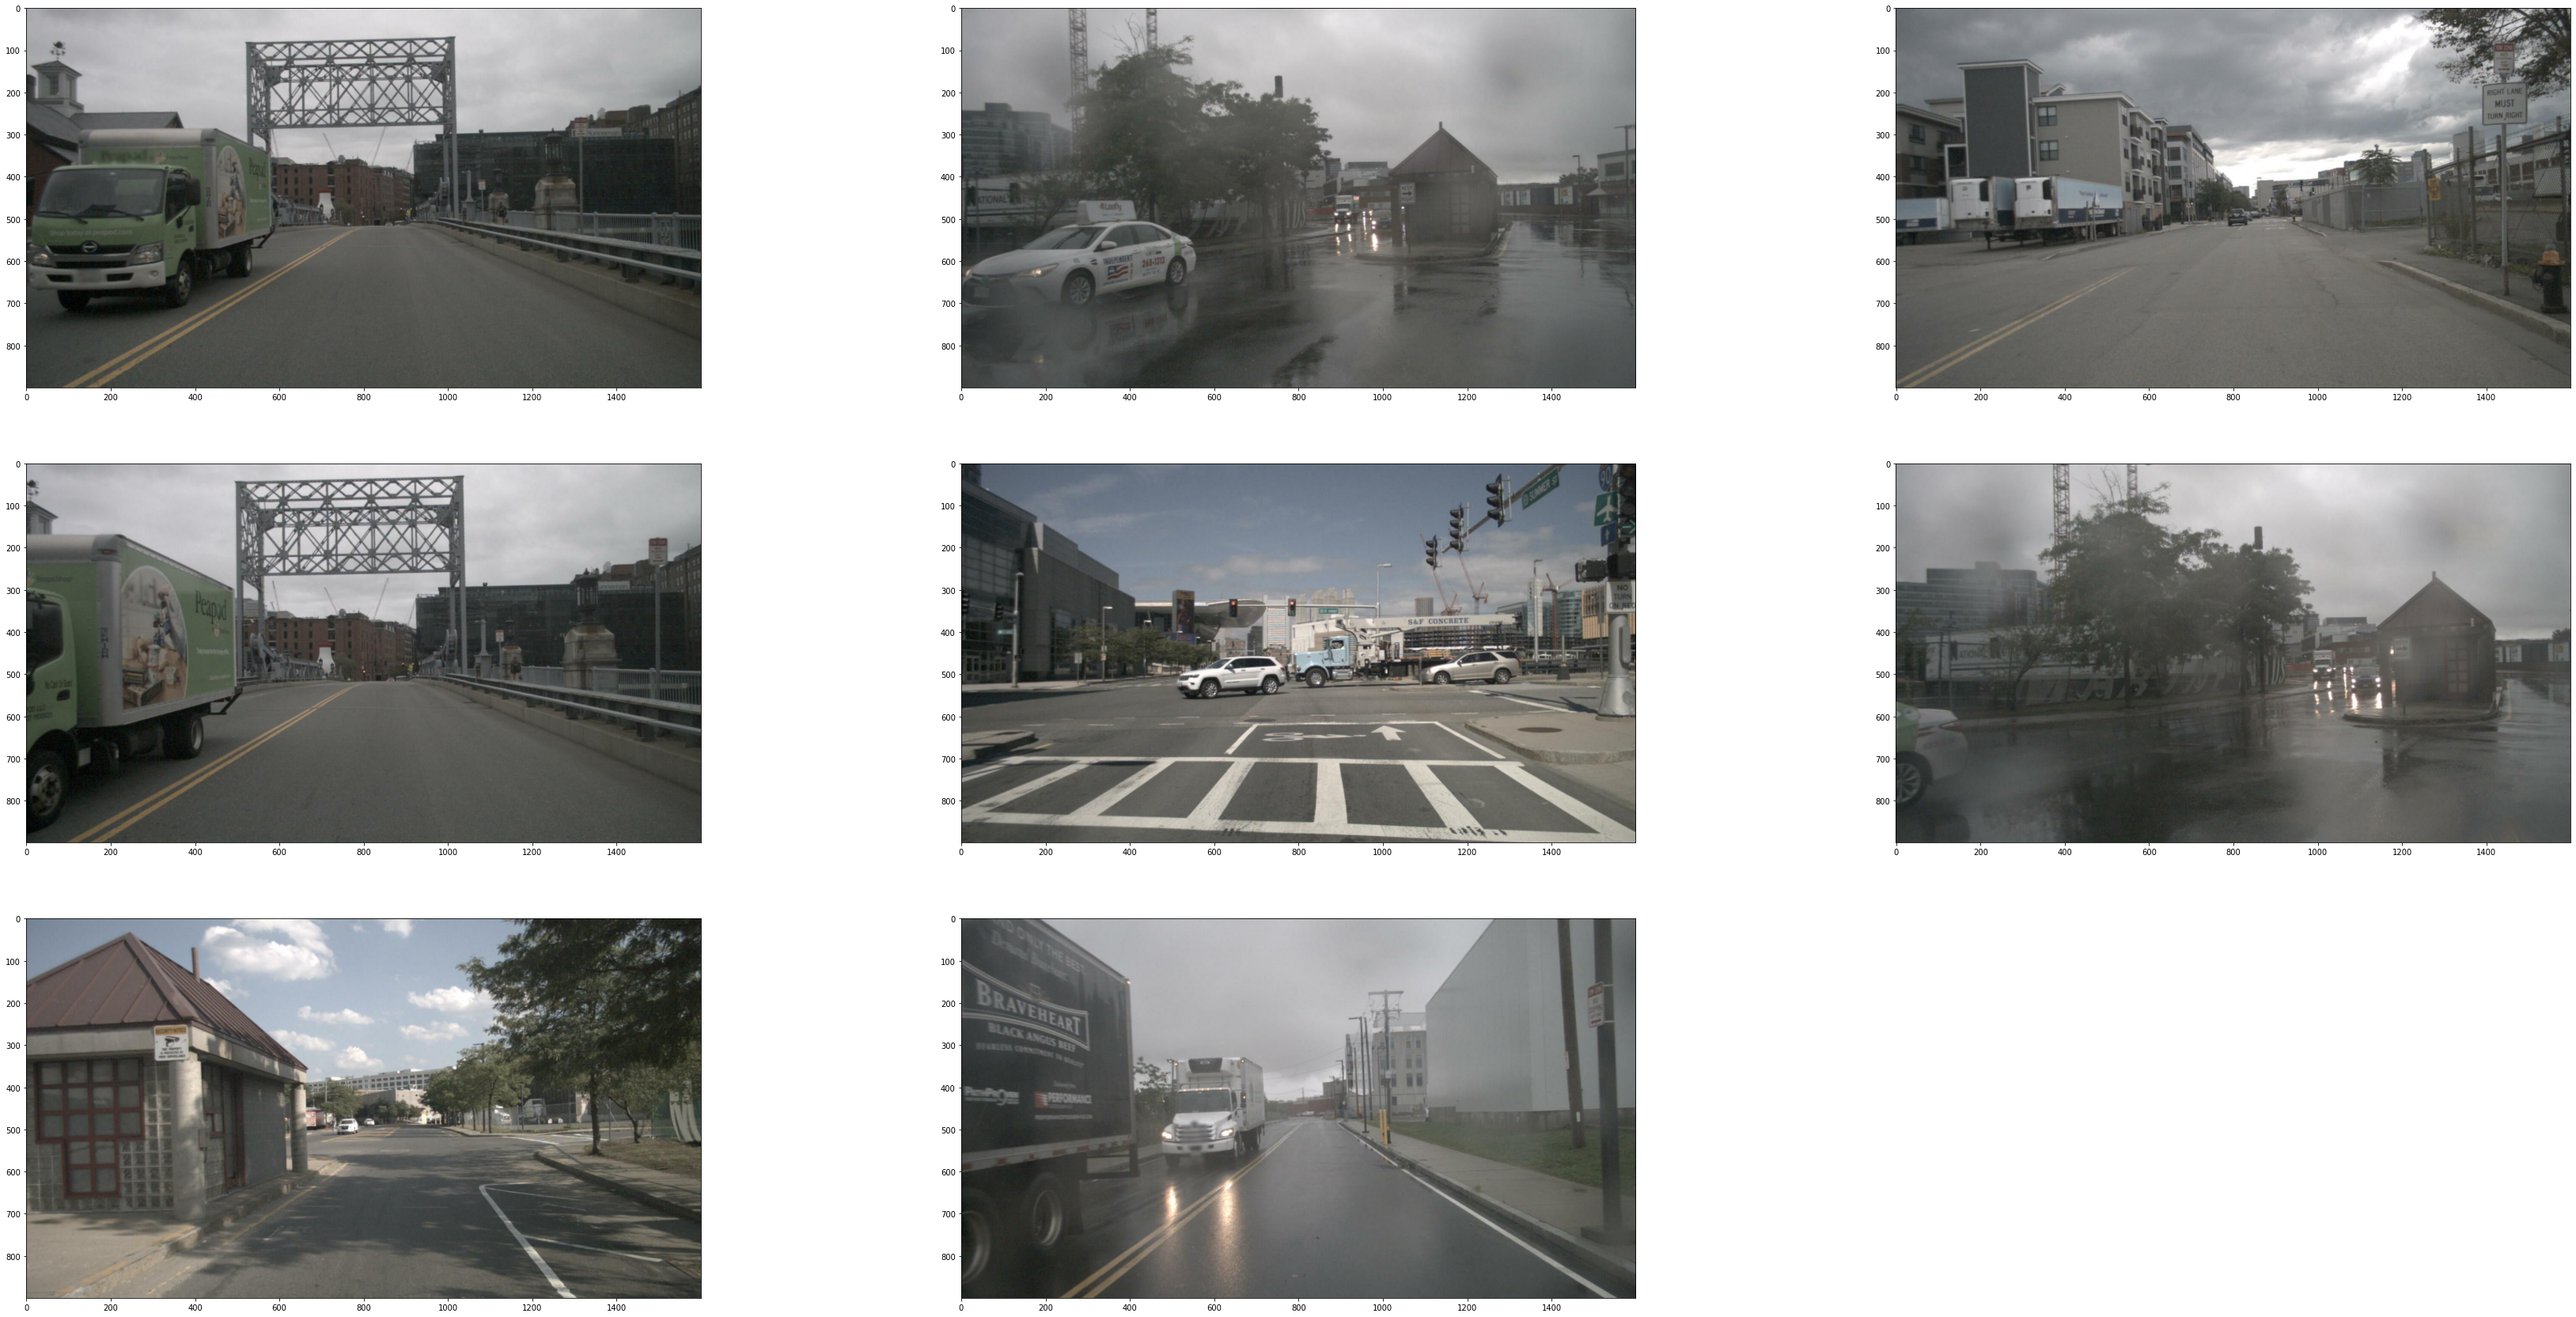

In [10]:
show_images(list(resultImages_2.keys()), sample=10)

image n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg
loaded
image n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg
loaded


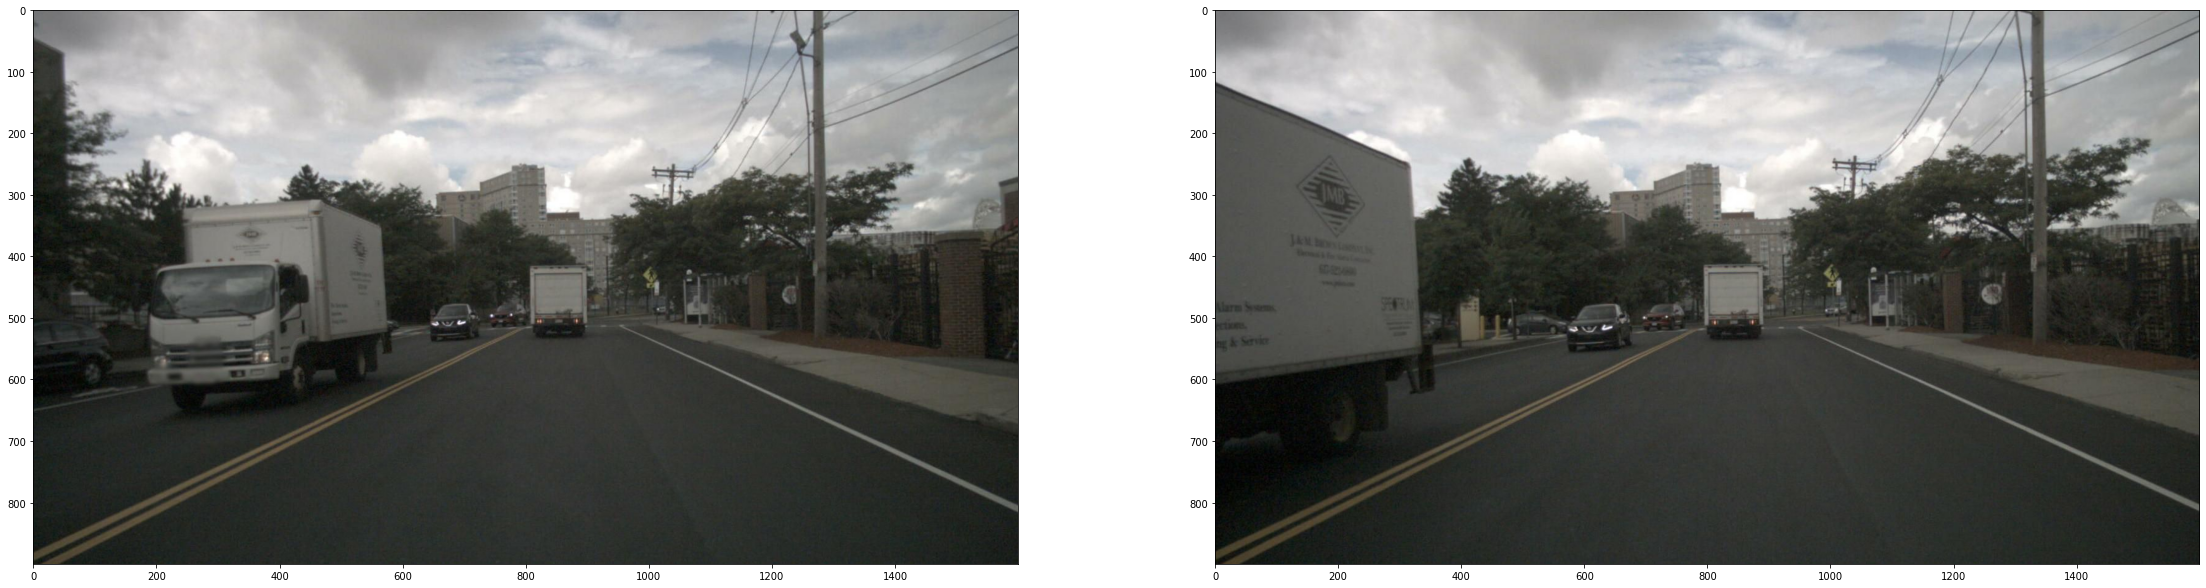

In [5]:
expected_imgs = ["n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg", "n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg"]
show_images(expected_imgs)

In [9]:
### Getting info about the expected images
from apperception.database import database
for img in expected_imgs:
    prefix = "samples/CAM_FRONT/"
    query = f"""SELECT \'Camera: \', Cameras.egoHeading, ST_X(Cameras.egoTranslation), ST_Y(Cameras.egoTranslation), ST_Z(Cameras.egoTranslation),
    \'Cars: \', table_0.itemId, getX(table_0.trajCentroids, Cameras.timestamp), getY(table_0.trajCentroids, Cameras.timestamp), 
    ST_Z(valueAtTimestamp(table_0.trajCentroids, Cameras.timestamp)), 
    \'Distance: \', distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp),
    \'CarHeading:\', valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp),
    \'RoadDirection for car:\', roadDirection(table_0.trajCentroids, Cameras.timestamp, valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp)::real),
    \'Ahead: \', ahead(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp) 
    FROM Item_General_Trajectory AS table_0, Cameras
                WHERE Cameras.filename = \'{prefix + img}\' AND table_0.cameraId = Cameras.cameraId 
                AND table_0.objectType LIKE 'vehicle%' 
                AND getX(table_0.trajCentroids, Cameras.timestamp) IS NOT NULL 
                AND angleBetween(facingRelative(table_0.itemHeadings, Cameras.egoHeading, Cameras.timestamp), -15, 15);
"""
    database.cursor.execute(query)
    result = database.cursor.fetchall()
    print(result)

[('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', 'd956aacf75284f1faa43a77d56c62a77', 1994.5838094924488, 1051.4624389946496, 0.8014999999999999, 'Distance: ', 67.24699591207033, 'CarHeading:', 58.552200247160485, 'RoadDirection for car:', 58.5522, 'Ahead: ', False), ('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', '6a81ab78eee3477e8509569a5d0a2217', 1893.895627360433, 1071.884001618687, 0.30499999999999994, 'Distance: ', 38.27007997676011, 'CarHeading:', 57.573803223303244, 'RoadDirection for car:', 58.327522, 'Ahead: ', True), ('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', 'fd2437defb374b4a96cbd6cf3d79be26', 1940.9462093600055, 1043.4989823998935, 0.02499999999999991, 'Distance: ', 16.763013357577563, 'CarHeading:', 58.01700000004624, 'RoadDirection for car:', 58.19608, 'Ahead: ', False)]
[('Camera: ', 59.43811, 1924.487978925326, 1055.023391492282, 0.0, 'Cars: ', 'd956aacf75284f1faa43a77d56c62a7

In [8]:
from apperception.database import database

query = f"""SELECT (1893.895627360433 - 1927.3625156512157) * COS(PI() * (59.95824 + 90) / 180) + (1071.884001618687 - 1053.3215015295318) * SIN(PI() * (59.95824 + 90) / 180),
         ST_AsText(convertCamera(st_point(1893.895627360433, 1071.884001618687), st_point(1927.3625156512157, 1053.3215015295318), 59.95824));"""
database.cursor.execute(query)
result = database.cursor.fetchall()
print(result)

[(38.26393585478368, 'POINT(-0.685736155436828 38.2639364478402)')]


In [ ]:
#### But for Scenic, all three cars should be in the scene ####
